## Analysis of an E-commerce Dataset Part 2

The goal of the second analysis task is to train linear regression models to predict users' ratings towards items. This involves a standard Data Science workflow: exploring data, building models, making predictions, and evaluating results. In this task, we will explore the impacts of feature selections and different sizes of training/testing data on the model performance. We will use another cleaned combined e-commerce sub-dataset that **is different from** the one in “Analysis of an E-commerce Dataset” task 1.

In [1]:
student_name = "Le Hai Anh (Hanie)"
student_id = "47702141"

## 1. Import Cleaned E-commerce Dataset
The csv file named 'cleaned_ecommerce_dataset.csv' is provided. You may need to use the Pandas method, i.e., `read_csv`, for reading it. After that, please print out its total length.

In [2]:
#Import functions
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
import math
from tabulate import tabulate

# Display the DataFrame
df = pd.read_csv('/Users/haianhle/Documents/ Macquarie MSBA 23’/ S1:2024/COMP6200/ Portfolio part 2 resources-20240319/cleaned_ecommerce_dataset.csv')
df

# Print out total length
print('The total length of the dataframe is:', len(df))

The total length of the dataframe is: 2685


## 2. Explore the Dataset

* Use the methods, i.e., `head()` and `info()`, to have a rough picture about the data, e.g., how many columns, and the data types of each column.
* As our goal is to predict ratings given other columns, please get the correlations between helpfulness/gender/category/review and rating by using the `corr()` method.

  Hints: To get the correlations between different features, you may need to first convert the categorical features (i.e., gender, category and review) into numerial values. For doing this, you may need to import `OrdinalEncoder` from `sklearn.preprocessing` (refer to the useful exmaples [here](https://pbpython.com/categorical-encoding.html))
* Please provide ___necessary explanations/analysis___ on the correlations, and figure out which are the ___most___ and ___least___ corrleated features regarding rating. Try to ___discuss___ how the correlation will affect the final prediction results, if we use these features to train a regression model for rating prediction. In what follows, we will conduct experiments to verify your hypothesis.

### Q&A: do we have to get the matrix for all columns or just the columns specified?


### 2.1. Data overview

In [3]:
# View first few rows of the data
df.head()

,userId,timestamp,review,item,rating,helpfulness,gender,category,item_id,item_price,user_city,Unnamed: 11,Unnamed: 12
0,4081,71900,Not always McCrap,McDonald's,4,3,M,Restaurants & Gourmet,41,30.74,4,NaN,-0.128821
1,4081,72000,I dropped the chalupa even before he told me to,Taco Bell,1,4,M,Restaurants & Gourmet,74,108.30,4,NaN,NaN
2,4081,72000,The Wonderful World of Wendy,Wendy's,5,4,M,Restaurants & Gourmet,84,69.00,4,NaN,NaN
3,4081,100399,They actually did it,"South Park: Bigger, Longer & Uncut",5,3,M,Movies,68,143.11,4,NaN,NaN
4,4081,100399,Hey! Gimme some pie!,American Pie,3,3,M,Movies,6,117.89,4,NaN,NaN


/Users/haianhle/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


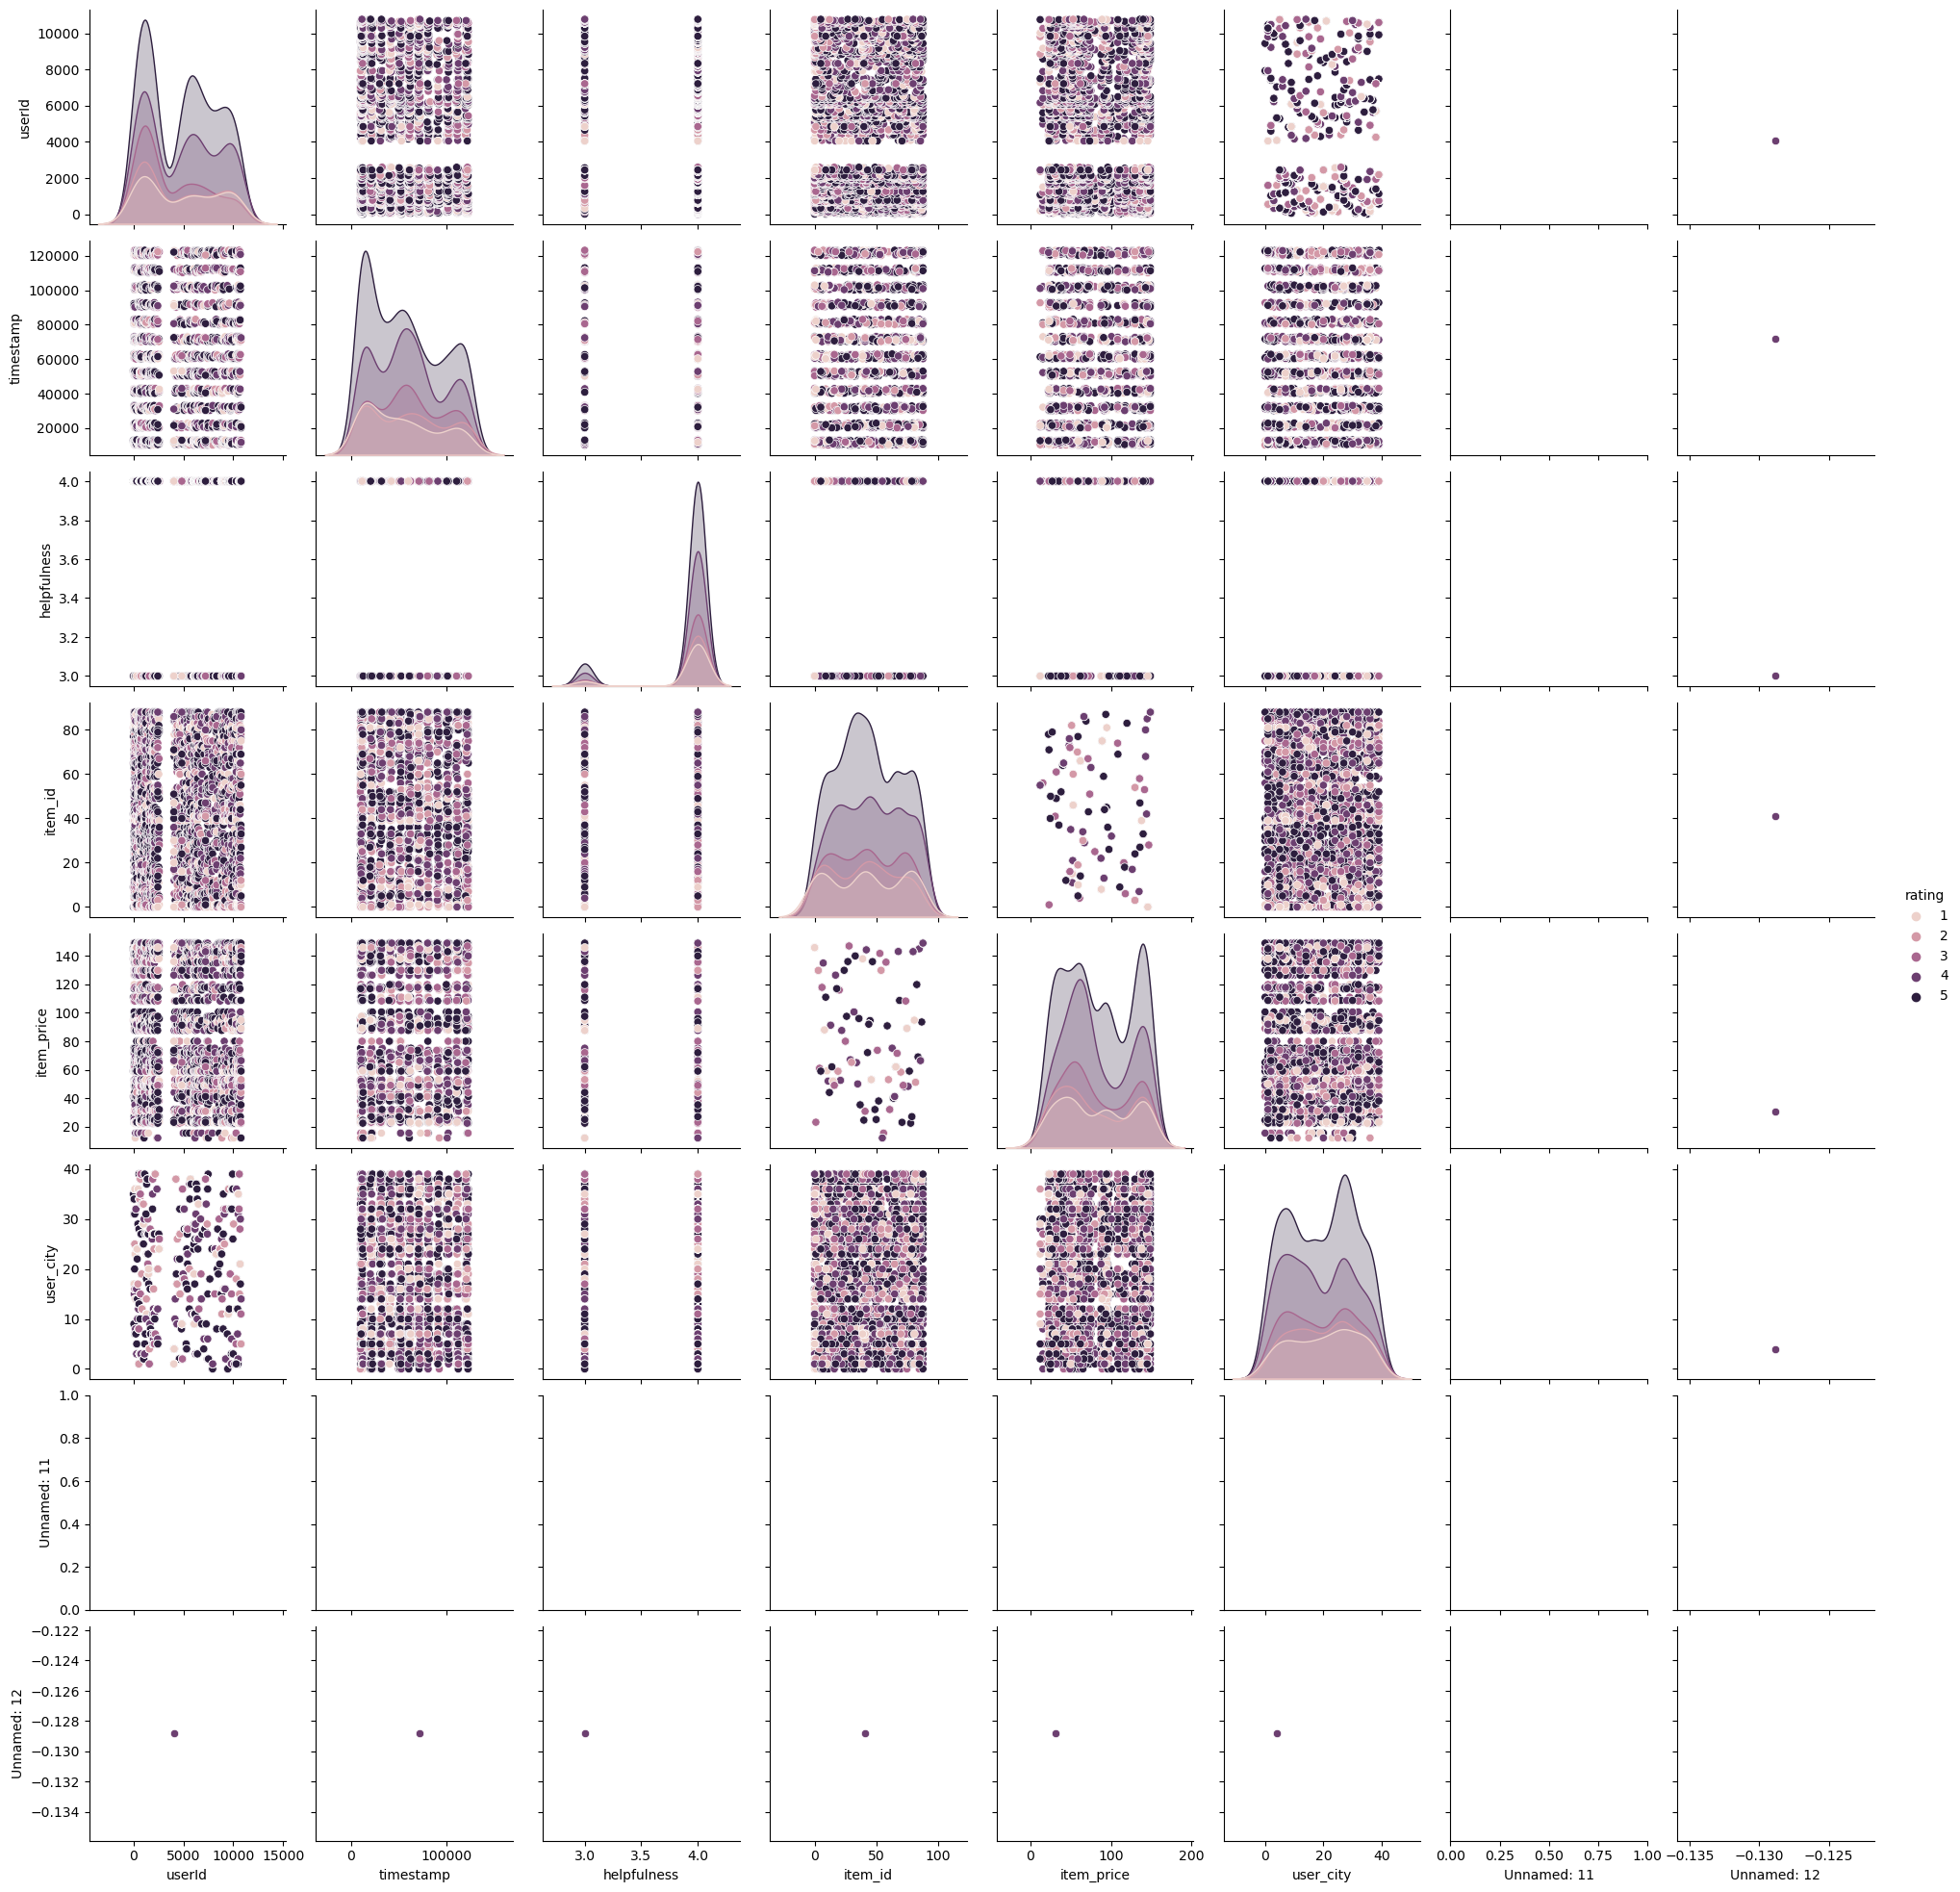

In [4]:
# Overview of all data to see whether there is any correlation between features
import seaborn as sns
sns.pairplot(df, hue='rating')

In [5]:
# Overview of the data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   userId       2685 non-null   int64  
 1   timestamp    2685 non-null   int64  
 2   review       2685 non-null   object 
 3   item         2685 non-null   object 
 4   rating       2685 non-null   int64  
 5   helpfulness  2685 non-null   int64  
 6   gender       2685 non-null   object 
 7   category     2685 non-null   object 
 8   item_id      2685 non-null   int64  
 9   item_price   2685 non-null   float64
 10  user_city    2685 non-null   int64  
 11  Unnamed: 11  0 non-null      float64
 12  Unnamed: 12  1 non-null      float64
dtypes: float64(3), int64(6), object(4)
memory usage: 272.8+ KB


- Here, we can see that rating and helpfulness columns have numerial values, which is different from the datatype of gender/category/review columns. Therefore, we need to convert them into the same datatype (numerical) to generate the correlations of each feature in the next part.

### 2.2. Correlations between helpfulness/gender/category/review and rating 

- Before getting the correlations, I check the unique values of each column to see how to convert those values into the same datatype.

In [6]:
# Check unique values in each columns 
unique_values_in_helpfulness = df['helpfulness'].unique()
print("Unique values in Helpfulness:",unique_values_in_helpfulness)

unique_values_in_gender = df['gender'].unique()
print("Unique values in Gender:",unique_values_in_gender)

unique_values_in_category = df['category'].unique()
print("Unique values in Category:",unique_values_in_category)

unique_values_in_review = df['review'].unique()
print("Unique values in Review:",unique_values_in_review)

unique_values_in_rating = df['rating'].unique()
print("Unique values in Rating:",unique_values_in_rating)

Unique values in Helpfulness: [3 4]
Unique values in Gender: ['M' 'F']
Unique values in Category: ['Restaurants & Gourmet' 'Movies' 'Media' 'Kids & Family'
 'Online Stores & Services' 'Games' 'Hotels & Travel' 'Books'
 'Personal Finance']
Unique values in Review: ['Not always McCrap' 'I dropped the chalupa even before he told me to'
 'The Wonderful World of Wendy' ... 'Good food!' 'Awesome Game.'
 'Great Service.']
Unique values in Rating: [4 1 5 3 2]


- Values in Rating and Helpfulness columns are numerical; therefore, values in Gender, Category and Review columns can be converted into numerical values based on the encoding strategy. 

In [7]:
# Initialize OrdinalEncoder
encoder = OrdinalEncoder()

# Encode categorical columns
encoded_df = encoder.fit_transform(df[['gender', 'category', 'review']])

# Convert encoded data back to Dataframe
encoded_df = pd.DataFrame(encoded_df, columns=['gender', 'category', 'review'])

# Concatenate encoded columns with numerical columns
final_df = pd.concat([encoded_df, df[['rating', 'helpfulness']]], axis=1)
final_df

,gender,category,review,rating,helpfulness
0,1.0,8.0,1618.0,4,3
1,1.0,8.0,1125.0,1,4
2,1.0,8.0,2185.0,5,4
3,1.0,5.0,2243.0,5,3
4,1.0,5.0,1033.0,3,3
...,...,...,...,...,...
2680,1.0,5.0,968.0,5,3
2681,1.0,8.0,920.0,5,3
2682,1.0,5.0,968.0,5,3
2683,1.0,1.0,372.0,5,4


In [8]:
# Check if datatype of all columns has been converted to numerical values
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gender       2685 non-null   float64
 1   category     2685 non-null   float64
 2   review       2685 non-null   float64
 3   rating       2685 non-null   int64  
 4   helpfulness  2685 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 105.0 KB


- Now that values in all columns have been encoded into numerical based on their group. However, the values in Review column are all different, it cannot be grouped so each review is assigned a number to be converted into numerical value.

In [9]:
# Calculate correlation matrix
correlation_matrix = final_df.corr()

# Print correlation matrix
print(correlation_matrix)

               gender  category    review    rating  helpfulness
gender       1.000000  0.022549 -0.037884 -0.034337     0.075947
category     0.022549  1.000000  0.001970 -0.163158    -0.013408
review      -0.037884  0.001970  1.000000 -0.036118    -0.028259
rating      -0.034337 -0.163158 -0.036118  1.000000    -0.007523
helpfulness  0.075947 -0.013408 -0.028259 -0.007523     1.000000


### 2.3. Analysis on the correlations

Draft: the values on the diagonal line of the matrix is a perfect 1.0 correlation because it is the correlation of the feature itself. 

Based on the above matrix of correlation, we can see that the relationship between rating and all other features (helpfulness/gender/category/review) are negative, indicating when rating score is high, other features of helpfulness/gender/category/review tend to be low and vice versa. Helpfulness (-0.007523) and gender (-0.0034337) are most correlated to rating while category (-0.163158) and review (-0.036118) are least correlated to rating. As a result, if we use these features to train a regression model for rating prediction, using features with highest correlation with rating will more likely to give better prediction result. However, even the strongest correlation is below 0.5, indicating a weak relationship with rating; therefore, the outcome might not be very precise.

## 3. Split Training and Testing Data
* Machine learning models are trained to help make predictions for the future. Normally, we need to randomly split the dataset into training and testing sets, where we use the training set to train the model, and then leverage the well-trained model to make predictions on the testing set.
* To further investigate whether the size of the training/testing data affects the model performance, please random split the data into training and testing sets with different sizes:
    * Case 1: training data containing 10% of the entire data;
    * Case 2: training data containing 90% of the entire data.
* Print the shape of training and testing sets in the two cases.

In [10]:
# Split the data into train set and test set for Case 1
train1, test1 = train_test_split(final_df, test_size=0.9, random_state=42)
print('Shape of training set Case 1: ',train1.shape)
print('Shape of test set Case 1: ',test1.shape)

# Split the data into train set and test set for Case 2
train2, test2 = train_test_split(final_df, test_size=0.1, random_state=42)
print('Shape of training set Case 2: ',train2.shape)
print('Shape of test set Case 12: ',test2.shape)

Shape of training set Case 1:  (268, 5)
Shape of test set Case 1:  (2417, 5)
Shape of training set Case 2:  (2416, 5)
Shape of test set Case 12:  (269, 5)


## 4. Train Linear Regression Models with Feature Selection under Cases 1 & 2
* When training a machine learning model for prediction, we may need to select the most important/correlated input features for more accurate results.
* To investigate whether feature selection affects the model performance, please select two most correlated features and two least correlated features from helpfulness/gender/category/review regarding rating, respectively.
* Train four linear regression models by following the conditions:
    - (model-a) using the training/testing data in case 1 with two most correlated input features
    - (model-b) using the training/testing data in case 1 with two least correlated input features
    - (model-c) using the training/testing data in case 2 with two most correlated input features
    - (model-d) using the training/testing data in case 2 with two least correlated input features
* By doing this, we can verify the impacts of the size of traing/testing data on the model performance via comparing model-a and model-c (or model-b and model-d); meanwhile the impacts of feature selection can be validated via comparing model-a and model-b (or model-c and model-d).    

### Case 1: training data containing 10% of the entire data
#### Model a - rating & two most correlated input features (helpfulness, gender)

In [11]:
#Train the model
x_train_a = train1[['helpfulness', 'gender']]
y_train_a = train1['rating']

x_test_a = test1[['helpfulness', 'gender']]
y_test_a = test1['rating']

model_a = linear_model.LinearRegression()
model_a.fit(x_train_a, y_train_a)

print("Model A with y = ", model_a.coef_, "* x + ", model_a.intercept_)

Model A with y =  [-0.14651872 -0.43196508] * x +  4.486090489958583


In [12]:
#printing the result for training data
predicted_train_a = model_a.predict(x_train_a)
mse_train_a = ((np.array(y_train_a)-predicted_train_a)**2).sum()/len(y_train_a)
r2_train_a = r2_score(y_train_a, predicted_train_a)
print("MSE of model A training data:", mse_train_a)
print("R Squared of model A training data:", r2_train_a)

MSE of model A training data: 1.6641214966927387
R Squared of model A training data: 0.028987567198036635


In [13]:

#printing the result for testing data
predicted_test_a = model_a.predict(x_test_a)
mse_test_a = ((np.array(y_test_a)-predicted_test_a)**2).sum()/len(y_test_a)
r2_test_a = r2_score(y_test_a, predicted_test_a)
print("MSE of model A test data:", mse_test_a)
print("R Squared of model A test data:", r2_test_a)

MSE of model A test data: 1.860535990321889
R Squared of model A test data: -0.020847858695246524


#### Model b - rating & two least correlated input features (category, review)

In [14]:
#Train the model
x_train_b = train1[['category', 'review']]
y_train_b = train1['rating']

x_test_b = test1[['category', 'review']]
y_test_b = test1['rating']

model_b = linear_model.LinearRegression()
model_b.fit(x_train_b, y_train_b)

print("Model B with y = ", model_b.coef_, "* x + ", model_b.intercept_)

Model B with y =  [-1.31822118e-01  1.21438182e-05] * x +  4.359413133316096


In [15]:
#printing the result for training data
predicted_train_b = model_b.predict(x_train_b)
mse_train_b = ((np.array(y_train_b)-predicted_train_b)**2).sum()/len(y_train_b)
r2_train_b = r2_score(y_train_b, predicted_train_b)
print("MSE of model B training data:", mse_train_b)
print("R Squared of model B training data:", r2_train_b)

MSE of model B training data: 1.6575324330519643
R Squared of model B training data: 0.03283227609004413


In [16]:
#printing the result for testing data
predicted_test_b = model_b.predict(x_test_b)
mse_test_b = ((np.array(y_test_b)-predicted_test_b)**2).sum()/len(y_test_b)
r2_test_b = r2_score(y_test_b, predicted_test_b)
print("MSE of model A test data:", mse_test_b)
print("R Squared of model A test data:", r2_test_b)

MSE of model A test data: 1.776581354691434
R Squared of model A test data: 0.025216775612666997


### Case 2: training data containing 90% of the entire data
#### Model c - rating & two most correlated input features (helpfulness, gender)

In [17]:
#Train the model
x_train_c = train2[['helpfulness', 'gender']]
y_train_c = train2['rating']

x_test_c = test2[['helpfulness', 'gender']]
y_test_c = test2['rating']

model_c = linear_model.LinearRegression()
model_c.fit(x_train_c, y_train_c)

print("Model C with y = ", model_c.coef_, "* x + ", model_c.intercept_)

Model C with y =  [-0.01270512 -0.09973812] * x +  3.7977272408821303


In [18]:
#printing the result for training data
predicted_train_c = model_c.predict(x_train_c)
mse_train_c = ((np.array(y_train_c)-predicted_train_c)**2).sum()/len(y_train_c)
r2_train_c = r2_score(y_train_c, predicted_train_c)
print("MSE of model C training data:", mse_train_c)
print("R Squared of model C training data:", r2_train_c)

MSE of model C training data: 1.8190895437035606
R Squared of model C training data: 0.0013825545177510445


In [19]:
#printing the result for testing data
predicted_test_c = model_c.predict(x_test_c)
mse_test_c = ((np.array(y_test_c)-predicted_test_c)**2).sum()/len(y_test_c)
r2_test_c = r2_score(y_test_c, predicted_test_c)
print("MSE of model C test data:", mse_test_c)
print("R Squared of model C test data:", r2_test_c)

MSE of model C test data: 1.7245375467700426
R Squared of model C test data: -0.005213879443114022


#### Model d - rating & two least correlated input features (category, review)

In [20]:
#Train the model
x_train_d = train2[['category', 'review']]
y_train_d = train2['rating']

x_test_d = test2[['category', 'review']]
y_test_d = test2['rating']

model_d = linear_model.LinearRegression()
model_d.fit(x_train_d, y_train_d)

print("Model D with y = ", model_d.coef_, "* x + ", model_d.intercept_)

Model D with y =  [-1.24834474e-01 -7.58022504e-05] * x +  4.422698922082496


In [21]:
#printing the result for training data
predicted_train_d = model_d.predict(x_train_d)
mse_train_d = ((np.array(y_train_d)-predicted_train_d)**2).sum()/len(y_train_d)
r2_train_d = r2_score(y_train_d, predicted_train_d)
print("MSE of model D training data:", mse_train_d)
print("R Squared of model D training data:", r2_train_d)

MSE of model D training data: 1.770154736554786
R Squared of model D training data: 0.028246076590768388


In [22]:
#printing the result for testing data
predicted_test_d = model_d.predict(x_test_d)
mse_test_d = ((np.array(y_test_d)-predicted_test_d)**2).sum()/len(y_test_d)
r2_test_d = r2_score(y_test_d, predicted_test_d)
print("MSE of model D test data:", mse_test_d)
print("R Squared of model D test data:", r2_test_d)

MSE of model D test data: 1.681992500504392
R Squared of model D test data: 0.019585157891782612


## 5. Evaluate Models
* Evaluate the performance of the four models with two metrics, including MSE and Root MSE
* Print the results of the four models regarding the two metrics

In [23]:
#obtain root MSE of train sets
root_mse_train_a = math.sqrt(mse_train_a)
root_mse_train_b = math.sqrt(mse_train_b)
root_mse_train_c = math.sqrt(mse_train_c)
root_mse_train_d = math.sqrt(mse_train_d)
print("Root MSE on train sets of 4 models A-D respectively:",root_mse_train_a, root_mse_train_b, root_mse_train_c, root_mse_train_d)

#obtain root MSE of test sets
root_mse_test_a = math.sqrt(mse_test_a)
root_mse_test_b = math.sqrt(mse_test_b)
root_mse_test_c = math.sqrt(mse_test_c)
root_mse_test_d = math.sqrt(mse_test_d)
print("Root MSE on test sets of 4 models A-D respectively:",root_mse_test_a, root_mse_test_b, root_mse_test_c, root_mse_test_d)

Root MSE on train sets of 4 models A-D respectively: 1.290008332024541 1.2874519148504011 1.3487362765580084 1.3304716218524866
Root MSE on test sets of 4 models A-D respectively: 1.3640146591301316 1.3328845991650717 1.3132164889194937 1.2969165356739007


In [24]:
#make a table for results of the 4 models regarding the 2 metrics: MSE and Root MSE

table1 = [['Model', 'Dataset', 'MSE', 'Root MSE'],
         ['A', 'Train', mse_train_a, root_mse_train_a],
         ['A', 'Test', mse_test_a, root_mse_test_a],
         ['B', 'Train', mse_train_b, root_mse_train_b],
         ['B', 'Test', mse_test_b, root_mse_test_b],
         ['C', 'Train', mse_train_c, root_mse_train_c],
         ['C', 'Test', mse_test_c, root_mse_test_c],
         ['D', 'Train', mse_train_d, root_mse_train_d],
         ['D', 'Test', mse_test_d, root_mse_test_d]]
print(tabulate(table1))

-----  -------  ------------------  ------------------
Model  Dataset  MSE                 Root MSE
A      Train    1.6641214966927387  1.290008332024541
A      Test     1.860535990321889   1.3640146591301316
B      Train    1.6575324330519643  1.2874519148504011
B      Test     1.776581354691434   1.3328845991650717
C      Train    1.8190895437035606  1.3487362765580084
C      Test     1.7245375467700426  1.3132164889194937
D      Train    1.770154736554786   1.3304716218524866
D      Test     1.681992500504392   1.2969165356739007
-----  -------  ------------------  ------------------


In [25]:
# Convert table1 to a dataframe
df_table1 = pd.DataFrame(table1[1:], columns=table1[0])
df_table1

,Model,Dataset,MSE,Root MSE
0,A,Train,1.664121,1.290008
1,A,Test,1.860536,1.364015
2,B,Train,1.657532,1.287452
3,B,Test,1.776581,1.332885
4,C,Train,1.819090,1.348736
5,C,Test,1.724538,1.313216
6,D,Train,1.770155,1.330472
7,D,Test,1.681993,1.296917


In [26]:
#add R-squared to the dataframe to make inferences on the results
df_table2 = pd.DataFrame(df_table1)

r_squared_values = [r2_train_a, r2_test_a,
                    r2_train_b, r2_test_b,
                    r2_train_c, r2_test_c,
                    r2_train_d, r2_test_d]

df_table2['R-squared'] = r_squared_values

print(tabulate(df_table2,tablefmt='presto'))

 0 | A | Train | 1.66412 | 1.29001 |  0.0289876
 1 | A | Test  | 1.86054 | 1.36401 | -0.0208479
 2 | B | Train | 1.65753 | 1.28745 |  0.0328323
 3 | B | Test  | 1.77658 | 1.33288 |  0.0252168
 4 | C | Train | 1.81909 | 1.34874 |  0.00138255
 5 | C | Test  | 1.72454 | 1.31322 | -0.00521388
 6 | D | Train | 1.77015 | 1.33047 |  0.0282461
 7 | D | Test  | 1.68199 | 1.29692 |  0.0195852


## 6. Visualize, Compare and Analyze the Results
* Visulize the results, and perform ___insightful analysis___ on the obtained results. For better visualization, you may need to carefully set the scale for the y-axis.
* Normally, the model trained with most correlated features and more training data will get better results. Do you obtain the similar observations? If not, please ___explain the possible reasons___.

### 6.1. Bar plot comparing MSE of each model 

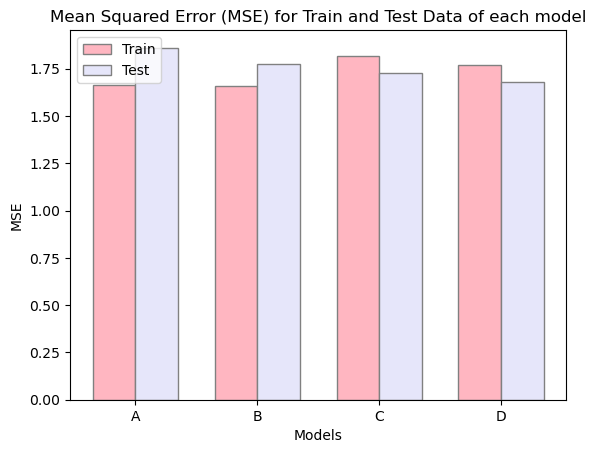

In [27]:
# Extract data for plotting
models = df_table1['Model'].unique()
mse_train = df_table1[df_table1['Dataset'] == 'Train'].set_index('Model').loc[models, 'MSE']
mse_test = df_table1[df_table1['Dataset'] == 'Test'].set_index('Model').loc[models, 'MSE']


# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(models))
r2 = [x + bar_width for x in r1]

# Create the double bar plot
plt.bar(r1, mse_train, color='#FFB6C1', width=bar_width, edgecolor='grey', label='Train')
plt.bar(r2, mse_test, color='#E6E6FA', width=bar_width, edgecolor='grey', label='Test')

# Add labels, title, and legend
plt.xlabel('Models')
plt.ylabel('MSE')
plt.title('Mean Squared Error (MSE) for Train and Test Data of each model')
plt.xticks([r + bar_width/2 for r in range(len(models))], models)
plt.legend()

# Show the plot
plt.show()

### 6.2. Bar plot comparing Root MSE of each model 

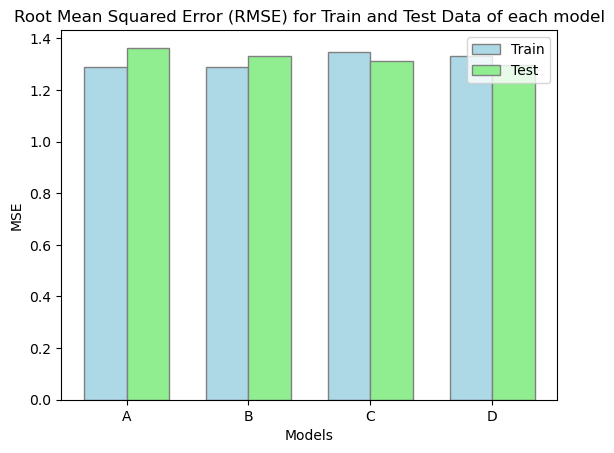

In [28]:
# Extract data for plotting
models = df_table1['Model'].unique()
mse_train = df_table1[df_table1['Dataset'] == 'Train'].set_index('Model').loc[models, 'Root MSE']
mse_test = df_table1[df_table1['Dataset'] == 'Test'].set_index('Model').loc[models, 'Root MSE']


# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(models))
r2 = [x + bar_width for x in r1]

# Create the double bar plot
plt.bar(r1, mse_train, color='#ADD8E6', width=bar_width, edgecolor='grey', label='Train')
plt.bar(r2, mse_test, color='#90EE90', width=bar_width, edgecolor='grey', label='Test')

# Add labels, title, and legend
plt.xlabel('Models')
plt.ylabel('MSE')
plt.title('Root Mean Squared Error (RMSE) for Train and Test Data of each model')
plt.xticks([r + bar_width/2 for r in range(len(models))], models)
plt.legend()

# Show the plot
plt.show()

### 6.3. Side-by-side plot comparing MSE and RMSE of each model 

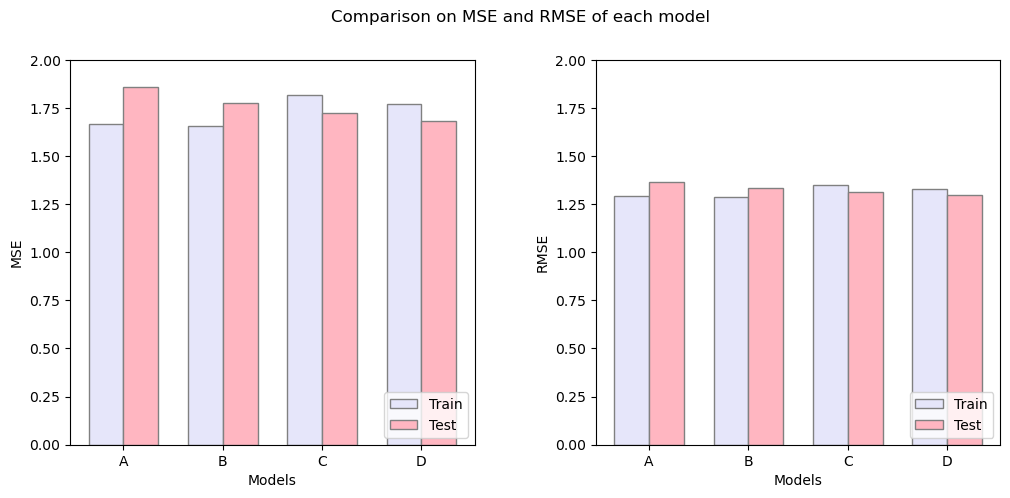

In [29]:
# Set the width of the bars
bar_width = 0.35
# Set double plot size
plt.figure(figsize=(12, 5))

# Set the positions of the bars on the x-axis for the first subplot
r1 = range(len(models))
r2 = [x + bar_width for x in r1]

# First subplot
#extract data for plotting
models = df_table1['Model'].unique()
mse_train = df_table1[df_table1['Dataset'] == 'Train'].set_index('Model').loc[models, 'MSE']
mse_test = df_table1[df_table1['Dataset'] == 'Test'].set_index('Model').loc[models, 'MSE']
#create the first subplot for the first bar graph
plt.subplot(1, 2, 1)
plt.bar(r1, mse_train, color='#E6E6FA', width=bar_width, edgecolor='grey', label='Train')
plt.bar(r2, mse_test, color='#FFB6C1', width=bar_width, edgecolor='grey', label='Test')
plt.ylim(0, 2.0)
plt.xlabel('Models')
plt.ylabel('MSE')
plt.xticks([r + bar_width/2 for r in range(len(models))], models)
plt.legend(loc='lower right')

# Second subplot
#extract data for plotting
models = df_table1['Model'].unique()
mse_train = df_table1[df_table1['Dataset'] == 'Train'].set_index('Model').loc[models, 'Root MSE']
mse_test = df_table1[df_table1['Dataset'] == 'Test'].set_index('Model').loc[models, 'Root MSE']
#create the second subplot for the second bar graph
plt.subplot(1, 2, 2)
plt.bar(r1, mse_train, color='#E6E6FA', width=bar_width, edgecolor='grey', label='Train')
plt.bar(r2, mse_test, color='#FFB6C1', width=bar_width, edgecolor='grey', label='Test')
plt.ylim(0, 2.0)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.xticks([r + bar_width/2 for r in range(len(models))], models)
plt.legend(loc='lower right')

# Add a title for the side-by-side plot
plt.suptitle('Comparison on MSE and RMSE of each model')

# Adjust layout and display the plot
plt.subplots_adjust(wspace=0.3)
plt.show()

### 6.4. Bar plot on the R-squared of each model

In [30]:
# Print table2 as a dataframe
df_table2

,Model,Dataset,MSE,Root MSE,R-squared
0,A,Train,1.664121,1.290008,0.028988
1,A,Test,1.860536,1.364015,-0.020848
2,B,Train,1.657532,1.287452,0.032832
3,B,Test,1.776581,1.332885,0.025217
4,C,Train,1.819090,1.348736,0.001383
5,C,Test,1.724538,1.313216,-0.005214
6,D,Train,1.770155,1.330472,0.028246
7,D,Test,1.681993,1.296917,0.019585


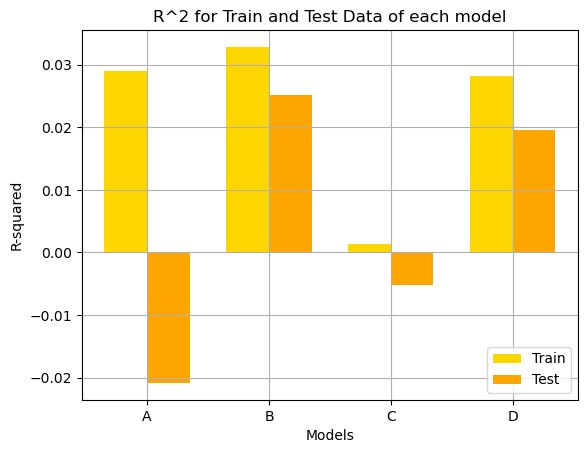

In [31]:
# Extract data for plotting
models = df_table2['Model'].unique()
r_squared_train = df_table2[df_table2['Dataset'] == 'Train']['R-squared']
r_squared_test = df_table2[df_table2['Dataset'] == 'Test']['R-squared']

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(models))
r2 = [x + bar_width for x in r1]

# Create the double bar plot
plt.bar(r1, r_squared_train, color='#FFD700', width=bar_width, label='Train')
plt.bar(r2, r_squared_test, color='#FFA500', width=bar_width, label='Test')

# Add labels, title, and legend
plt.xlabel('Models')
plt.ylabel('R-squared')
plt.title('R^2 for Train and Test Data of each model')
plt.xticks([r + bar_width/2 for r in range(len(models))], models)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### 6.5. Compare and Analyze the Results

#### 6.5.1. Verify the impacts of the size of traing/testing data on the model performance via comparing Model A and Model C

In most cases, a lower MSE or RMSE value indicates better predictive performance of a model. When comparing model A (train set = 10% data) and model C (train set = 90% data) (both models used 2 most correlated input features), train set of model A and test set of model C have lower MSE/RMSE, indicating a better performance. However, when considering R-Squared, model A have considerable difference of r-squared score between train set and test set when compared to model C with less difference between the 2 sets. Particularly, r-squared of model A is closer to 1 for the training set (0.0289) but much lower for the test set (-0.0208), consequently, model A may be overfitting. Model-A may struggle to generalize well to unseen data due to limited training data, leading to overfitting. Model-C, with more training data, is expected to generalize better to new data, reducing the risk of overfitting. In conclusion, by comparing model A and model C, we should consider the size of traing/testing data on the model performance: the larger proportion of a dataset should first be used to train the model to reduce overfitting and increase generalisation, and then the smaller proportion of data should be used for testing.

#### 6.5.2. Validate the impacts of feature selection via comparing Model C and Model D
Both model C and model D used the same train set with 90% of the data, however, model C used two most correlated input features while model D used two least correlated input features. We will now examine the impact of feature selection via comparing the 2 models. From figure 6.3 above, we can see that model C has lower MSE/RMSE for train set and test set compared to model D, indicating a better performance of model C. On the other hand, model C has less difference in R-squared score between train set and test set comparing with model D. It can be inferred that model C is less overfitting than model D. By concluding that model C performs better than model D, we can validate that selecting the most correlated features will result in better performance of the model. 

From the 2 inferences above we can conclude that the model trained with most correlated features and more training data will get better results. 

## 7. Data Science Ethics
*Please read the following examples [Click here to read the example_1.](https://www.vox.com/covid-19-coronavirus-us-response-trump/2020/5/18/21262265/georgia-covid-19-cases-declining-reopening) [Click here to read the example_2.](https://viborc.com/ethics-and-ethical-data-visualization-a-complete-guide/)

*Then view the picture ![My Image](figure_portfolio2.png "This is my image")
Please compose an analysis of 100-200 words that evaluates potential ethical concerns associated with the infographic, detailing the reasons behind these issues.


Potential ethical concerns with the above infographic is the accuracy of the data itself. The correct information can be found in [this official link of Olympics medal table](https://olympics.com/en/olympic-games/beijing-2008/medals). In table1, the top countries receiving most total medals are: United States, China, Russia, Britain, Australia, France, Germany with 112, 100, 60, 51, 46, 43, 41 respectively. The last 2 ranking in table1 is wrong due to the wrong number obtained. For details, please refer to the following image:
<img src="https://raw.githubusercontent.com/MQ-COMP2200-COMP6200/portfolio-part-2-Hanie180/146e5840070b8730423c17df2fe762e44b196284/Olympics%202008%20-%20Total%20medals%20ranking.png?token=BCVOLGLXU47CBEM3Q566YYLGATVOI" alt="total medal raking" width="500" height="400">


In table2, the top countries receiving most gold medals are correct in terms of order. However, there is a mistake in the number of gold medals received, particularly: 
- China 48 instead of 51
- Russia 24 instead of 23
For details, please refer to the following image:
<img src="https://raw.githubusercontent.com/MQ-COMP2200-COMP6200/portfolio-part-2-Hanie180/146e5840070b8730423c17df2fe762e44b196284/Olympics%202008%20-%20Gold%20medals%20ranking.png?token=BCVOLGLRLUUXIIA5MD2MARTGATVOI" alt="gold medal raking" width="500" height="400">

The reasons might be:  
- Lack of verification: the data may not have been verified or validated by credible sources or authorities.
- Speed and convenience: unofficial sources may provide data quickly and more conveniently, especially when official data sources have delays or restrictions.
- Incomplete or biased information: unreliable sources may provide incomplete or biased information, leading to inaccuracies or misinterpretations of the data.
- Lack of data quality controls: unreliable sources may lack proper data quality controls, validation processes, or transparency in data collection methods.